### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to find overbought or oversold scenarios in stock, currency or commodity prices. The RSI is an oscillator (a line chart that moves between two extremes) and can have a value between 0 and 100. The indicator was originally introduced in the seminal 1978 book, "New Concepts in Technical Trading Systems" written by J. Welles Wilder Jr.

Traditional interpretation of the RSI is that values of 70 or above indicate that a security is becoming overvalued or overbought and may be due for a trend reversal or correction in price. An RSI value of 30 or below indicates an undervalued or oversold scenario.

See: [Bollinger Bands Notebook](https://www.kaggle.com/ankitmalik/algotrading-part-1-bollinger-bands)

In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5 MB 2.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=567a7669c95967283700733ade0838ce88a46313efc01d0fa9005e592bfb2530
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=6a8928f3ca8208dd65a8bddf304842756465c0ce62b0658489d82845469f5827
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:
      Successfully uninstalled lxml-4.5.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Import all necessary libraries

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.dates import num2date, date2num
warnings.simplefilter("ignore")
%matplotlib inline

### Get stock data from Yahoo Finance
I have chosen Bajaj Finance as an example. It is a high beta stocks and thus provides opportunites for short term (less than 365 days) trading.
Each entry represents 1 day staring from 1 Jan 2011

In [3]:
import yfinance as yf
ticker='BAJFINANCE.NS'
tickerData = yf.Ticker(ticker)
df = tickerData.history(period='1d', start='2011-1-1')

Below is the function to complete RSI usinf EMA and SMA.

In [4]:
def rsi(df, window=14):
    close = df['Close']
    
    # Price increase or decrease over previous day
    dif = close.diff()
    dif = dif[1:] 
    
    # pos_m identifies stock price going up
    # neg_m udentifies stock price going down
    pos_m, neg_m = dif.copy(), dif.copy()
    pos_m[pos_m < 0] = 0
    neg_m[neg_m > 0] = 0
    
    # Positive Rolling Mean Exponential
    prme = pos_m.ewm(span=window).mean()
    # Negative Rolling Mean Exponential
    nrme = neg_m.abs().ewm(span=window).mean()
    
    # Ratio of magnitude of up move to down move
    RSE = prme / nrme
    RSIE = 100.0 - (100.0 / (1.0 + RSE))
    df['rsie'] = RSIE
    
    # Positive Rolling Mean Simple
    prms = pos_m.rolling(window).mean()
    # Negative Rolling Mean Simple
    nrms = neg_m.abs().rolling(window).mean()

    RSS = prms / nrms
    RSIS = 100.0 - (100.0 / (1.0 + RSS))
    
    df['rsis'] = RSIS
    return df
df = rsi(df)

In [5]:
df['Date'] = df.index
df['DateY'] = df['Date'].apply(lambda x: date2num(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")))

In [6]:
def candlestick(ax, quotes, width=0.2, colorup='g', colordown='r', alpha=1.0):
    OFFSET = width / 2.0

    lines = []
    patches = []
    for q in quotes:
        t, open, close, high, low = q[:5]

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(t, t), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True,
        )

        rect = Rectangle(
            xy=(t - OFFSET, lower),
            width=width,
            height=height,
            facecolor=color,
            edgecolor=color,
        )
        rect.set_alpha(alpha)

        lines.append(vline)
        patches.append(rect)
        ax.add_line(vline)
        ax.add_patch(rect)
    ax.autoscale_view()

    return lines, patches

Here I have plotted RSI computed using Exponential Moving Average. We can also use Simple Moving Average instead.

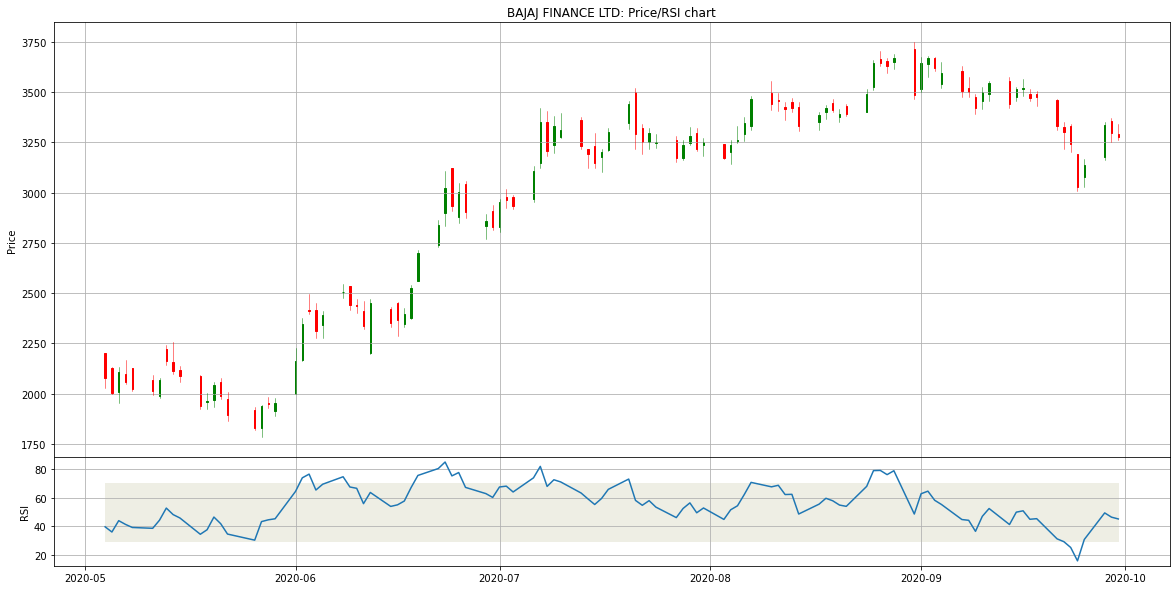

In [7]:
def plot_rsi(df, start_date='2020-05-01', end_date='2020-09-30'):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    df = df[(df.index>=start_date) & (df.index<=end_date)]
    ax1 = plt.subplot2grid((5,4), (0,0), rowspan=4, colspan=4)
    
    candlestick(ax1, np.array(df[['DateY', 'Open', 'Close', 'High', 'Low']]))
    plt.title("BAJAJ FINANCE LTD: Price/RSI chart")
    plt.ylabel("Price")
    ax1.grid(True)
    
    ax2 = plt.subplot2grid((5,4), (4,0), rowspan=1, colspan=4, sharex=ax1)
    ax2.fill_between(num2date(df['DateY']), 30, 70, color = '#eeeee4')
    ax2.plot(num2date(df['DateY']), df['rsie'])
    plt.ylabel("RSI")
    ax2.grid(True)
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

plot_rsi(df)

Thanks for reading!